## Importing the libraries needed

In [ ]:
!pip install ktrain

In [2]:
import ktrain
from ktrain import text
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

## Creating a dataframe using pandas

The training and testing sets have already been formed using the train_test_split function, in a 90/10 ratio


In [5]:
training_set = pd.read_csv('training.csv',encoding="UTF-8")
testing_set = pd.read_csv('testing.csv', encoding="UTF-8")

## Splitting the dataframe into a training set and a validation set by 70/30

In [6]:
X_train, X_test, y_train, y_test = train_test_split(training_set['encabezado'], training_set['clase'], shuffle = True, test_size = 0.2)

## Converting data to features for BERT

In [7]:
X_train = numpy.array(X_train)
X_test = numpy.array(X_test)
y_train = numpy.array(y_train)
y_test = numpy.array(y_test)

In [8]:
(X_train_bert, y_train_bert), (X_test_bert, y_test_bert), preproc = text.texts_from_array(x_train = X_train, y_train = y_train, x_test = X_test, y_test = y_test, 
                                                                                 class_names = ['0', '1'], preprocess_mode = 'bert', lang = 'es', 
                                                                                 maxlen = 128)

downloading pretrained BERT model (multi_cased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: es


Is Multi-Label? False
preprocessing test...
language: es


task: text classification


## Loading BERT in a learner object

In [9]:
model = text.text_classifier('bert', train_data = (X_train_bert, y_train_bert), preproc = preproc)
learner = ktrain.get_learner(model, train_data = (X_train_bert, y_train_bert), val_data = (X_test_bert, y_test_bert), batch_size = 16)

Is Multi-Label? False
maxlen is 128


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


## Using the function lr_find(), we can find the best learning rate for the model

In [10]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
99/99 [==============================] - 63s 440ms/step - loss: 0.6933 - accuracy: 0.5114
Epoch 2/1024
99/99 [==============================] - 44s 449ms/step - loss: 0.6834 - accuracy: 0.5587
Epoch 3/1024
99/99 [==============================] - 45s 456ms/step - loss: 0.6499 - accuracy: 0.6402
Epoch 4/1024
99/99 [==============================] - 46s 460ms/step - loss: 0.4948 - accuracy: 0.7715
Epoch 5/1024
99/99 [==============================] - 46s 463ms/step - loss: 0.2820 - accuracy: 0.8908
Epoch 6/1024
99/99 [==============================] - 46s 466ms/step - loss: 0.1707 - accuracy: 0.9413
Epoch 7/1024
99/99 [==============================] - 46s 467ms/step - loss: 0.1833 - accuracy: 0.9287
Epoch 8/1024
99/99 [==============================] - 46s 468ms/step - loss: 0.6116 - accuracy: 0.6105
Epoch 9/1024
99/99 [==============================] - 15s 153ms/step - loss: 0.7328 - accurac

### A visual representation of the loss 

Three possible suggestions for LR from plot:
	Longest valley (red): 3.82E-06
	Min numerical gradient (purple): 4.01E-06
	Min loss divided by 10 (omitted from plot): 5.72E-06


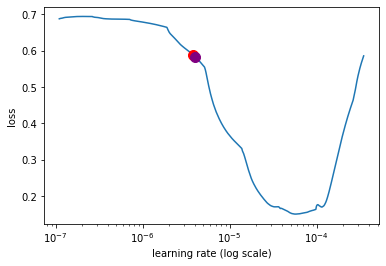

In [11]:
learner.lr_plot(suggest='true')

## Using that learning rate, the model is trained

In [12]:
learner.autofit(4.01E-06)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 4.01e-06...
Epoch 1/1024
99/99 [==============================] - 72s 553ms/step - loss: 0.6609 - accuracy: 0.6016 - val_loss: 0.5765 - val_accuracy: 0.7273
Epoch 2/1024
99/99 [==============================] - 50s 502ms/step - loss: 0.5156 - accuracy: 0.7645 - val_loss: 0.4289 - val_accuracy: 0.8131
Epoch 3/1024
99/99 [==============================] - 52s 522ms/step - loss: 0.3819 - accuracy: 0.8340 - val_loss: 0.3028 - val_accuracy: 0.8662
Epoch 4/1024
99/99 [==============================] - 50s 510ms/step - loss: 0.2785 - accuracy: 0.8965 - val_loss: 0.2364 - val_accuracy: 0.8990
Epoch 5/1024
99/99 [==============================] - 51s 513ms/step - loss: 0.2124 - accuracy: 0.9167 - val_loss: 0.2323 - val_accuracy: 0.9040
Epoch 6/1024
99/99 [==============================] - 51s 514ms/step - loss: 0.1447 - ac

## Validation of the model using the validation set

In [13]:
learner.validate(val_data = (X_test_bert, y_test_bert))

13/13 [==============================] - 8s 250ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       200
           1       0.92      0.94      0.93       196

    accuracy                           0.93       396
   macro avg       0.93      0.93      0.93       396
weighted avg       0.93      0.93      0.93       396



array([[183,  17],
       [ 11, 185]])

## Creating a predictor using the trained model

In [14]:
predictor = ktrain.get_predictor(learner.model, preproc)

## Confusion Matrix for the validation results

In [17]:
test_headlines = numpy.array(testing_set['encabezado'])
test_class = numpy.array(testing_set['clase'])

In [18]:
p = predictor.predict(test_headlines)

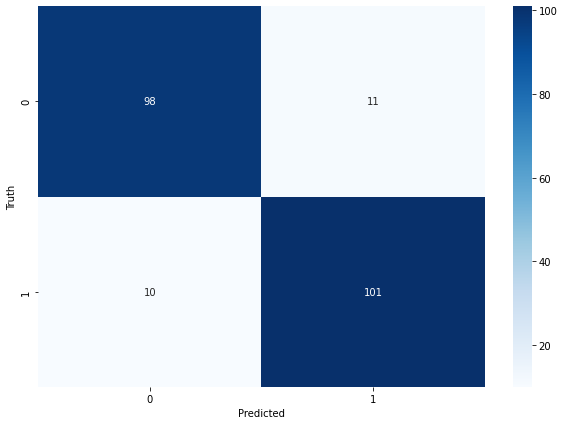

In [20]:
cm = confusion_matrix(p, test_class)
fig, ax = plt.subplots(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Truth')
fig.savefig('cm.png')

In [21]:
from sklearn.metrics import classification_report
target_names = ['0', '1']
print(classification_report(test_class, p))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       108
           1       0.91      0.90      0.91       112

    accuracy                           0.90       220
   macro avg       0.90      0.90      0.90       220
weighted avg       0.90      0.90      0.90       220

